# Spectrogram-based CNN for the Tensorflow Speech Recognition Challenge (~ 90 % accuracy)


The goal of this challenge is to classify 65,000 one-second audio clips for 30 short words, building an algorithm that understands simple spoken command.

This notebooks shows all the steps needed to create a speech model using short audio tracks in a tidy way.


## <ins>Notes</ins>

- The notebook is using the CNN architecture published at:
https://blogs.rstudio.com/ai/posts/2018-06-06-simple-audio-classification-keras/

- The current pipeline is using batch processing and online augmentation, randomly modifying the audio clips before being used to train the network.


## <ins>Methods</ins>

- The audio clips are analyzed as images computing Mel-frequency cepstral normalized coefficients (MFCCs). MFCCs are an alternative representation of the Mel-frequency spectrogram. The MFCCs can be obtained applying the discrete cosine transform (DCT) to a Mel-frequency spectrogram (take a look to this article: https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0). Additional information can be found in any digital signal processing textbook (concepts such as Fourier transform and Short Time Fourier Transform are fundamental).

- To improve the robustness of the algorithm, some online data augmentation methods are sequentially applied to the raw audio clips before computing MFCCs: addition of background noise, audio shifting and pitch modification. Each audio was edited independently with these filters with a chance of 70% in each sequential step.

In [ ]:
#%env JOBLIB_TEMP_FOLDER=/tmp

In [1]:
#%%capture

!pip install pyunpack
!pip install patool

import os
os.environ["CUDA_VISIBLE_DEVICES"]='0,1'
os.system('apt-get install p7zip')

import glob
from pyunpack import Archive
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,activations
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import load_model
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
from sklearn.preprocessing import StandardScaler,MinMaxScaler,LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import math
import shutil
import pickle
import multiprocessing
import gc

tf.random.set_seed(9)
#%load_ext tensorboard   

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 77 kB 3.5 MB/s  eta 0:00:01
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
tf.__version__

'2.3.0'

In [4]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 16004833456978788454,
 name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 3136750241752955725
 physical_device_desc: "device: XLA_CPU device",
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15703681280
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16521993829591240572
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0",
 name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13391059132466721177
 physical_device_desc: "device: XLA_GPU device"]

In [5]:
root_path = "/kaggle"

# 1. Copy the train data into the "output" directory:

In [6]:

if not os.path.exists(root_path + '/working/train/'):
    os.makedirs(root_path + '/working/train/')
    Archive(root_path + '/input/tensorflow-speech-recognition-challenge/train.7z').extractall(root_path + '/working')
    

train_path = root_path + '/working/train/audio/'

## Visualization of the Mel spectrogram of a sample audio:

In [7]:
train_audio_sample = os.path.join(train_path, "yes/0a7c2a8d_nohash_0.wav")
x,sr = librosa.load(train_audio_sample, sr = 16000)

ipd.Audio(x, rate=sr)

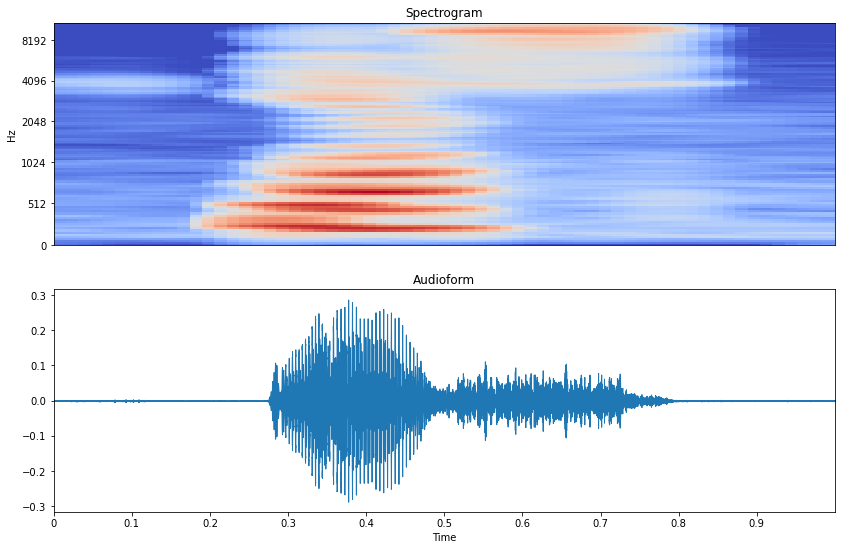

In [8]:
hop_length = 256
S = librosa.feature.melspectrogram(x, sr=sr, n_fft=4096, hop_length=hop_length)
logS = librosa.power_to_db(abs(S))

plt.figure(figsize=(14, 9))

plt.figure(1)

plt.subplot(211)
plt.title('Spectrogram')
librosa.display.specshow(logS, sr=sr, hop_length=hop_length, x_axis= None, y_axis='mel')
#plt.colorbar(format='%+2.0f dB')

plt.subplot(212)
plt.title('Audioform')
librosa.display.waveplot(x, sr=sr)


## Visualization of MFCCs

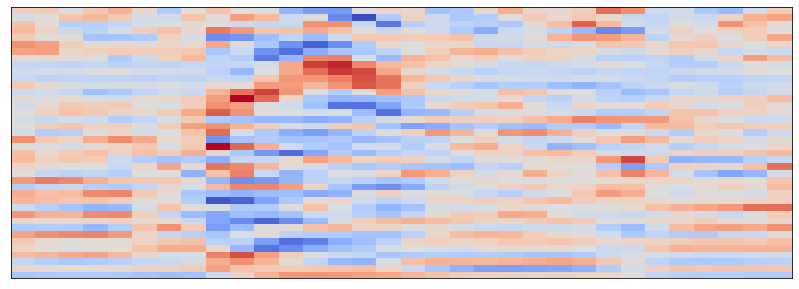

In [9]:
mfccs = librosa.feature.mfcc(x, sr=sr,  n_mfcc=40) 
scaler = StandardScaler()
ee= scaler.fit_transform(mfccs.T)

plt.figure(figsize=(14, 5))
librosa.display.specshow(ee.T)

# 2. Functions we need for this pipeline

In [10]:
def pad_audio(samples, L):
    if len(samples) >= L: 
        return samples
    else: 
        return np.pad(samples, pad_width=(L - len(samples), 0), mode='constant', constant_values=(0, 0))
    
    
def chop_audio(samples, L=16000):
    while True:
        beg = np.random.randint(0, len(samples) - L)
        yield samples[beg: beg + L]


def choose_background_generator(sound, backgrounds, max_alpha = 0.7):
    if backgrounds is None:
        return sound
    my_gen = backgrounds[np.random.randint(len(backgrounds))]
    background = next(my_gen) * np.random.uniform(0, max_alpha)
    augmented_data = sound + background
    augmented_data = augmented_data.astype(type(sound[0]))
    return augmented_data 


def random_shift(sound, shift_max = 0.2, sampling_rate = 16000):
    shift = np.random.randint(sampling_rate * shift_max)
    out = np.roll(sound, shift)
    # time shift
    if shift > 0:
        out[:shift] = 0
    else:
        out[shift:] = 0
    return out


def random_change_pitch(x, sr=16000):
    pitch_factor = np.random.randint(1, 4)
    out = librosa.effects.pitch_shift(x, sr, pitch_factor)
    return out


def random_speed_up(x):
    where = ["start", "end"][np.random.randint(0, 1)]
    speed_factor = np.random.uniform(0, 0.5)
    up = librosa.effects.time_stretch(x, 1 + speed_factor)
    up_len = up.shape[0]
    if where == "end":
        up = np.concatenate((up, np.zeros((x.shape[0] - up_len,))))
    else:
        up = np.concatenate((np.zeros((x.shape[0] - up_len,)), up))
    return up


def get_image_list(train_audio_path):
    classes = os.listdir(train_audio_path)
    classes = [thisclass for thisclass in classes if thisclass != '_background_noise_']
    index = [i for i,j in enumerate(classes)]
    outlist = []
    labels = []
    for thisindex,thisclass in zip(index, classes):
        filelist = [f for f in os.listdir(os.path.join(train_audio_path, thisclass)) if f.endswith('.wav')]
        filelist = [os.path.join(train_audio_path, thisclass, x) for x in filelist]
        outlist.append(filelist)
        labels.append(np.full(len(filelist), fill_value= thisindex))   
    return outlist,labels,dict(zip(classes,index))


def split_train_test_stratified_shuffle(images_list, labels, train_size = 0.9):
    classes_size = [len(x) for x in images_list]
    classes_vector = [np.arange(x) for x in classes_size]
    total = np.sum(classes_size)
    total_train = [int(train_size * total * x) for x in classes_size / total]
    train_index = [np.random.choice(x,y,replace=False) for x,y in zip(classes_size,total_train)]
    validation_index = [np.setdiff1d(i,j) for i,j in zip(classes_vector,train_index)]

    train_set = [np.array(x)[idx] for x,idx in zip(images_list,train_index)]
    validation_set = [np.array(x)[idx] for x,idx in zip(images_list,validation_index)]
    train_labels = [np.array(x)[idx] for x,idx in zip(labels,train_index)]
    validation_labels = [np.array(x)[idx] for x,idx in zip(labels,validation_index)]

    train_set = np.array([element for array in train_set for element in array])
    validation_set = np.array([element for array in validation_set for element in array])
    train_labels = np.array([element for array in train_labels for element in array])
    validation_labels = np.array([element for array in validation_labels for element in array])

    train_shuffle = np.random.permutation(len(train_set))
    validation_shuffle =  np.random.permutation(len(validation_set))

    train_set = train_set[train_shuffle]
    validation_set = validation_set[validation_shuffle]
    train_labels = train_labels[train_shuffle]
    validation_labels = validation_labels[validation_shuffle]
    
    return train_set,train_labels,validation_set,validation_labels

        
def preprocess_data(file, background_generator, target_sr = 16000, n_mfcc = 40, threshold = 0.7):
    # downsample to 16 kHz
    x,sr = librosa.load(file, sr = target_sr)
    x = pad_audio(x, sr)
    if np.random.uniform(0, 1) > threshold:
        x = choose_background_generator(x, background_generator) # add noinse to 30% of data
    if np.random.uniform(0, 1) > threshold:
        x = random_shift(x) 
    if np.random.uniform(0, 1) > threshold: 
        x = random_change_pitch(x) 
    if np.random.uniform(0, 1) > threshold:
        x = random_speed_up(x) 
    mfccs = librosa.feature.mfcc(x, sr=sr,  n_mfcc=n_mfcc) # transpose for sklearn
    mfccs = np.moveaxis(mfccs, 1, 0)
    #scaler = MinMaxScaler() 
    scaler = StandardScaler() 
    mfccs_scaled = scaler.fit_transform(mfccs)
    return mfccs_scaled.reshape(mfccs_scaled.shape[0], mfccs_scaled.shape[1], 1) # channels last


class data_generator(Sequence):
    def __init__(self, x_set, y_set, batch_size, background_generator):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.background_generator = background_generator
        #self.on_epoch_end()

    def __len__(self):
        return  math.ceil(len(self.x) / self.batch_size)

    def __getitem__(self, idx):
        idx_from = idx * self.batch_size
        idx_to = (idx + 1) * self.batch_size
        batch_x = self.x[idx_from:idx_to]
        batch_y = self.y[idx_from:idx_to]
        x = [preprocess_data(elem, self.background_generator) for elem in batch_x] 
        y = batch_y
        return np.array(x), np.array(y)
    
    #def on_epoch_end(self):
    #    print("Index epoch: %s, total samples %s" %(self.idx, (self.idx + 1) * self.batch_size))
        

def build_model(n_classes, input_shape):
    model_input = keras.Input(shape=input_shape)
    img_1 = layers.Convolution2D(filters = 32, kernel_size = (3,3), padding = "same", activation=activations.relu)(model_input)
    img_1 = layers.MaxPooling2D(pool_size=(2, 2))(img_1)
    img_1 = layers.Convolution2D(filters = 64, kernel_size = (3,3), padding = "same", activation=activations.relu)(img_1)
    img_1 = layers.MaxPooling2D(pool_size=(2, 2))(img_1)
    img_1 = layers.Convolution2D(filters = 128, kernel_size = (3,3), padding = "same", activation=activations.relu)(img_1)
    img_1 = layers.MaxPooling2D(pool_size=(2, 2))(img_1)
    img_1 = layers.Convolution2D(filters = 256, kernel_size = (3,3), padding = "same", activation=activations.relu)(img_1)
    img_1 = layers.MaxPooling2D(pool_size=(2, 2))(img_1)
    img_1 = layers.Dropout(rate=0.25)(img_1)
    img_1 = layers.Flatten()(img_1)
    img_1 = layers.Dense(128, activation=activations.relu)(img_1)
    img_1 = layers.Dropout(rate=0.5)(img_1)
    model_output = layers.Dense(n_classes, activation=activations.softmax)(img_1)
    model = keras.Model(model_input, model_output)
    return model


def multiclass_roc(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    all_labels = np.unique(y_test)

    for (idx, c_label) in enumerate(all_labels):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

# 3. Loading data

## Background data paths

In [11]:
# Load data with backgrounds

wavfiles = glob.glob(os.path.join(train_path, "_background_noise_/*wav"))
wavfiles = [librosa.load(elem, sr = 16000)[0] for elem in wavfiles]
background_generator = [chop_audio(x) for x in wavfiles]

## Training data paths, split train-test via stratified sampling, call a data generator for Keras

In [12]:
# load train

images_list,labels,classes_map =  get_image_list(train_path)

train_set,train_labels,validation_set,validation_labels = split_train_test_stratified_shuffle(images_list,labels)
train_datagen = data_generator(train_set, train_labels, 40, background_generator)
validation_datagen = data_generator(validation_set, validation_labels,40,  None)

# 4. Preliminar testing

## Preprocessor works

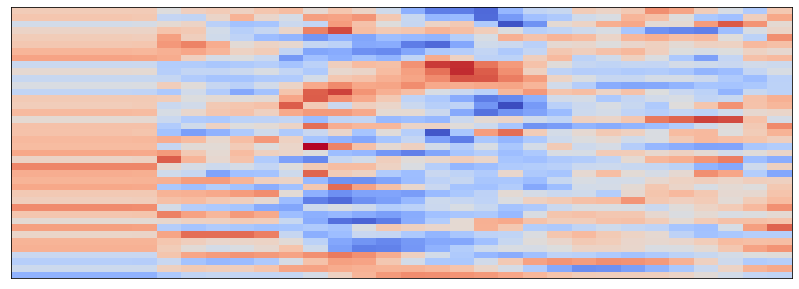

In [13]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(preprocess_data(train_audio_sample, None).reshape(32, 40).T)

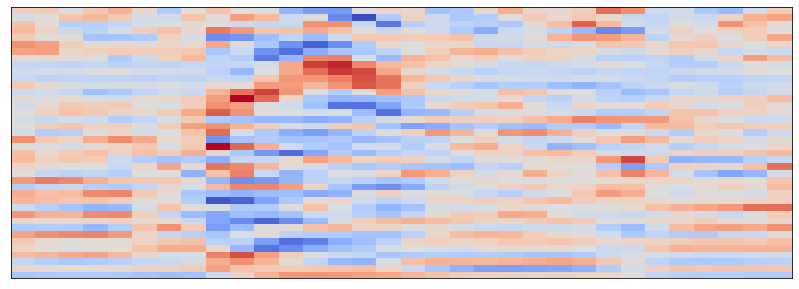

In [14]:
plt.figure(figsize=(14, 5))
librosa.display.specshow(preprocess_data(train_audio_sample, background_generator).reshape(32, 40).T)

# Data augmentation works

## Random shift

In [15]:
start_random = random_shift(x)
ipd.Audio(start_random , rate=sr)

## Increase speed

In [16]:
higher_speed = random_speed_up(x)
ipd.Audio(higher_speed , rate=sr)

## Change pitch

In [17]:
pitch_changed = random_change_pitch(x)
ipd.Audio(pitch_changed, rate=sr)

## Train not in validation

In [18]:
inv_map =  {v: k for k, v in classes_map.items()}
any_present=[i in validation_set for i in train_set]
np.any(any_present)

False

## Same order in data and labels

In [ ]:
# Same order in 

test1 = np.random.randint(10, 100, 10)

train_set[test1],[inv_map[int(i)] for i in train_labels[test1]]

In [19]:
test1 = np.random.randint(10, 100, 10)
validation_set[test1],[inv_map[int(i)] for i in validation_labels[test1]]

(array(['/kaggle/working/train/audio/zero/cee22275_nohash_0.wav',
        '/kaggle/working/train/audio/zero/9a69672b_nohash_4.wav',
        '/kaggle/working/train/audio/sheila/dec73123_nohash_0.wav',
        '/kaggle/working/train/audio/three/563aa4e6_nohash_3.wav',
        '/kaggle/working/train/audio/yes/ceaadb24_nohash_1.wav',
        '/kaggle/working/train/audio/yes/2c6d3924_nohash_0.wav',
        '/kaggle/working/train/audio/house/b1edd209_nohash_0.wav',
        '/kaggle/working/train/audio/down/2c6d3924_nohash_0.wav',
        '/kaggle/working/train/audio/right/f19c1390_nohash_1.wav',
        '/kaggle/working/train/audio/tree/e98cb283_nohash_1.wav'],
       dtype='<U56'),
 ['zero',
  'zero',
  'sheila',
  'three',
  'yes',
  'yes',
  'house',
  'down',
  'right',
  'tree'])

## Stratified sampling works

In [20]:
unique, counts = np.unique(validation_labels, return_counts=True)
x=dict(zip(unique, counts))
out = pd.DataFrame(sorted(x.items(), key=lambda kv: kv[0]))
out.drop(0, inplace = True, axis = 1)
out = out.apply(lambda x: 100 * x/sum(x))

total_labels = [y for x in labels for y in x]
unique, counts = np.unique(total_labels, return_counts=True)
y=dict(zip(unique, counts))
out2 = pd.DataFrame(sorted(y.items(), key=lambda kv: kv[0]))
out2.drop(0, inplace = True, axis = 1)

out2 = out2.apply(lambda x: 100 * x/sum(x))

In [21]:
out2.join(out, lsuffix='_left', rsuffix='_right')[:5]

,1_left,1_right
0,3.635605,3.638606
1,3.652601,3.654024
2,3.640240,3.638606
3,3.672687,3.669442
4,3.669597,3.669442


In [22]:
np.allclose(out.iloc[:,0].values, out2.iloc[:,0].values,  atol=0.01)

True

# 5. Build and train the model

In [23]:
# check format, channel last, (x_train.shape[0], rows, cols, 1)
print(keras.backend.image_data_format())

channels_last


## Build the model

In [24]:
rows = 32
columns = 40
batch_size = 100
epochs = 50
base_path = root_path + "/working/models"

if not os.path.exists(base_path):
    os.makedirs(base_path)

train_size = train_set.shape[0]
validation_size = validation_set.shape[0]
steps_per_epoch = train_size//batch_size

lr = 1e-3
#epoch_decay = 8 # decay each epoch_decay epochs
#decay_steps = epoch_decay * train_size//batch_size
#lr_schedule = keras.optimizers.schedules.ExponentialDecay(
#    lr, decay_steps = decay_steps, decay_rate=0.96, staircase=True
#)
tensorboard_dir=base_path + "/logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_dir)

checkpoint_filepath = os.path.join(base_path, 'cp-{epoch:04d}.ckpt')
    
    
checkpoint_callback = keras.callbacks.ModelCheckpoint(
        filepath= checkpoint_filepath,
        save_best_only=True,
        save_weights_only=True,
        monitor='val_acc',
        mode='max',
        verbose=1)

reduce_lr_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                                                       patience=3, min_lr=1e-5, vebose=1)

    
earlystop_callback = keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=1e-3,
        patience=5,
        verbose=1)
    
optimizer = keras.optimizers.Adam(learning_rate = lr)
loss_fn = keras.losses.SparseCategoricalCrossentropy()
acc_metric = keras.metrics.SparseCategoricalAccuracy()
    
model = build_model(len(classes_map), (rows, columns, 1))
model.compile(optimizer = optimizer, loss = loss_fn, metrics= [acc_metric])   
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 40, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 40, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 20, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 20, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 10, 64)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 10, 128)        73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 5, 128)        

## Fit the model

In [ ]:
#!tensorboard --logdir=/home/user/Documentos/kaggle/working/model/logs

In [ ]:
# Load the extension and start TensorBoard

history = model.fit(train_datagen,
                    steps_per_epoch= steps_per_epoch,
                    epochs = epochs,
                    validation_data = validation_datagen,
                    validation_steps = validation_size//batch_size,
                    callbacks=[earlystop_callback, reduce_lr_callback, checkpoint_callback, tensorboard_callback],
                    use_multiprocessing=True)

Epoch 1/50
582/582 [==============================] - 434s 745ms/step - loss: 3.1297 - sparse_categorical_accuracy: 0.0899 - val_loss: 2.2381 - val_sparse_categorical_accuracy: 0.3176
Epoch 2/50
470/582 [=======================>......] - ETA: 1:14 - loss: 1.9907 - sparse_categorical_accuracy: 0.3836

In [ ]:
shutil.rmtree(train_path)
gc.collect()

In [ ]:
# Visualize history
# Plot history: Loss
plt.plot(history.history['val_loss'], label = "val_loss")
plt.plot(history.history['loss'], label = "loss")
plt.title('Loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

# Plot history: Accuracy
plt.plot(history.history['sparse_categorical_accuracy'], label = "accuracy")
plt.plot(history.history['val_sparse_categorical_accuracy'], label = "val_accuracy")
plt.title('Accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

In [ ]:
if not os.path.exists(root_path + '/working/test/'):
    os.makedirs(root_path + '/working/test/')
    Archive(root_path + '/input/tensorflow-speech-recognition-challenge/test.7z').extractall(root_path + '/working')

test_path = root_path + '/working/test'

In [ ]:
test_data,test_labels,_ = get_image_list(test_path) # single folder
test_data = test_data[0]
test_labels = test_labels[0]

test_datagen = data_generator(test_data, test_labels, batch_size,  None)
test_size = len(test_data)
test_steps = np.ceil(test_size / (batch_size))  # steps same than train; https://github.com/keras-team/keras/issues/3477             
y_pred = model.predict_generator(test_datagen, steps = test_steps, verbose=1)

In [ ]:
y_labs = np.argmax(y_pred, axis=1)

In [ ]:
# Checking some predictions

In [ ]:
classes_map

In [ ]:
inv_map = inv_map = {v: k for k, v in classes_map.items()}

In [ ]:
train_audio_sample =  test_data[16]
x,sr = librosa.load(train_audio_sample, sr = 16000)

ipd.Audio(x, rate=sr)

In [ ]:
inv_map[y_labs[16]]

In [ ]:
train_audio_sample =  test_data[100]
x,sr = librosa.load(train_audio_sample, sr = 16000)

ipd.Audio(x, rate=sr)

In [ ]:
inv_map[y_labs[100]]

In [ ]:
train_audio_sample =  test_data[1001]
x,sr = librosa.load(train_audio_sample, sr = 16000)

ipd.Audio(x, rate=sr)

In [ ]:
inv_map[y_labs[1001]]

In [ ]:
shutil.rmtree(test_path)

In [ ]:
my_submission = pd.DataFrame({'fname':  test_data, 'label': [inv_map[x] for x in y_labs]})
my_submission.to_csv('submission.csv', index=False)